In [7]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from PIL import Image
from math import pi
import cv2
import math 
import pandas as pd
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [8]:
width = 22.5 # mm
resolution = 6000 #px
fs = round((width/ resolution), 4)
period = round(1 / fs, 3)

print(fs)
print(period)

0.0037
270.27


In [9]:
def sin(x, frequency, phase):
    return 0.5 + 0.5*np.sin(frequency * x*np.pi + phase)

In [10]:
def get_image(y):
    print(min(y),max(y))
    y = np.array(y)*255
    x = np.array([y for _ in range(301)])
    data = Image.fromarray(x)
    plt.imshow(data)
    #plt.axis("off")
    plt.show()

In [11]:
def get_mat(y):
    y = np.array(y)*255
    x = np.array([y for _ in range(301)])
    return x 

In [12]:
def discretization(freq, phase):
    height = 300
    y = []
    x = 0.0
    print(freq)
    while x < 1/fs * height:
        y0 = integrate.quad(lambda x: sin(x, freq, phase), x, x+1/fs)[0]/period
        y.append(round(y0,2))
        x += 1/fs

    get_image(y)
    return y 

0.0007400000000000001
0.01 0.99


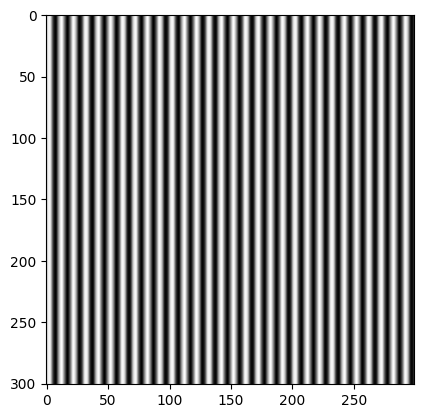

0.0012333333333333332
0.02 0.98


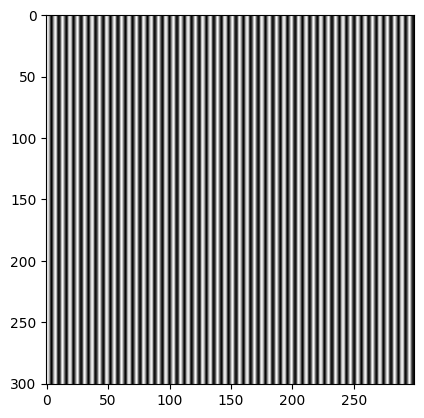

0.00185
0.18 0.82


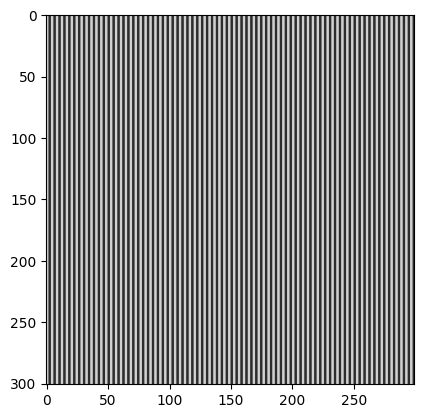

0.0037
0.18 0.82


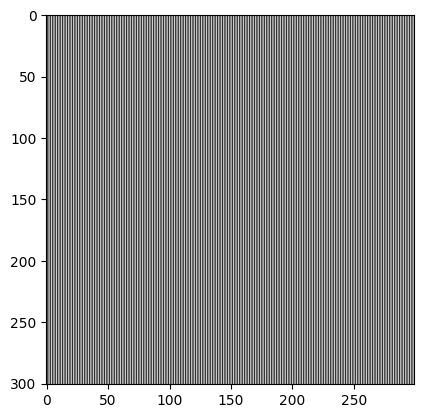

0.005217
0.32 0.68


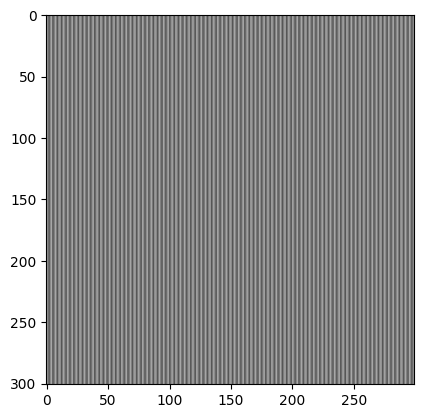

0.0074
0.5 0.5


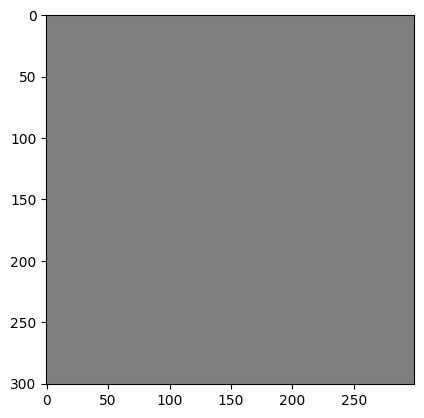

0.0111
0.39 0.61


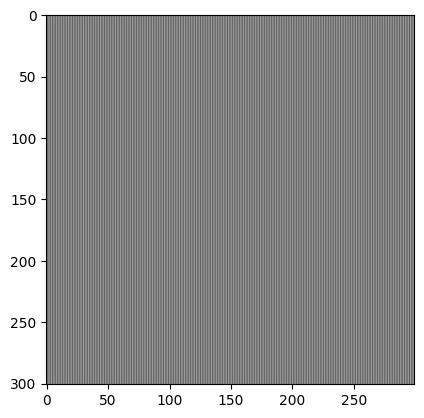

0.0148
0.5 0.5


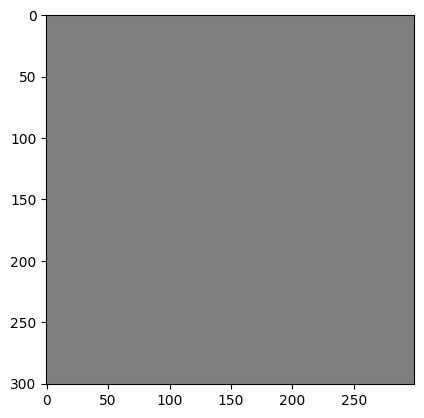

0.018500000000000003
0.44 0.56


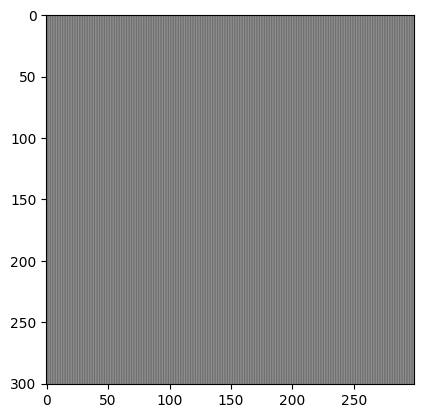

0.0222
0.5 0.5


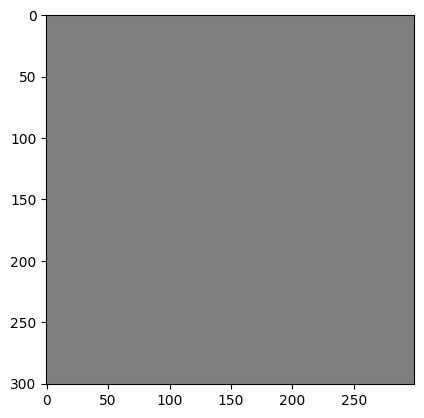

0.0259
0.45 0.55


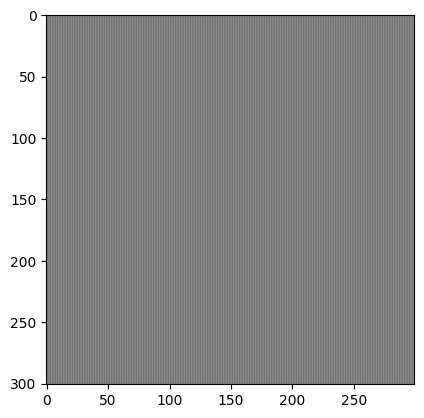

0.037000000000000005
0.5 0.5


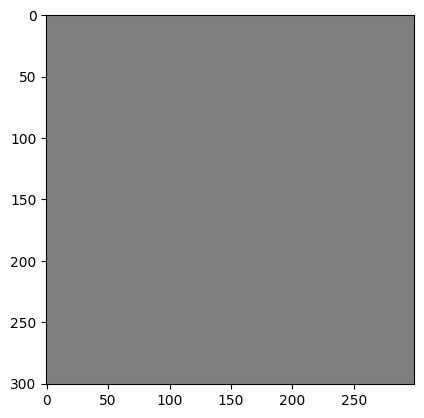

In [13]:
pars = [1/5, 1/3, 1/2, 1, 1.41, 2, 3, 4, 5, 6,7,10]
list_sample = []
for i, par  in enumerate(pars):
    list_sample.append(discretization(par*fs, 0))

0.0007400000000000001
0.02 0.98


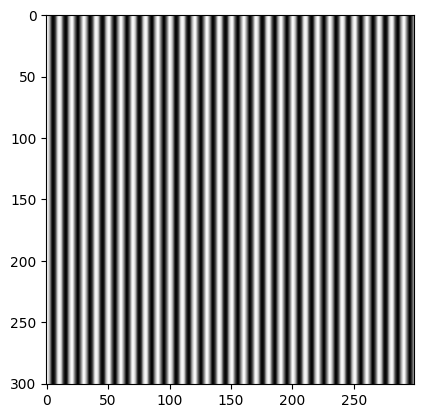

0.0012333333333333332
0.02 0.98


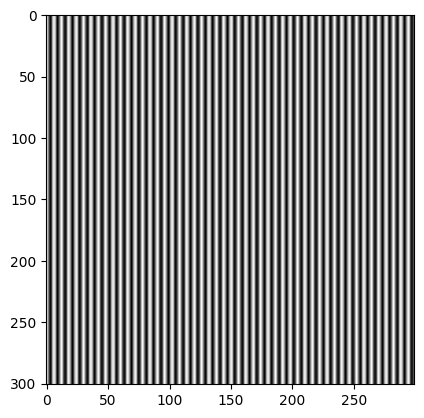

0.00185
0.06 0.94


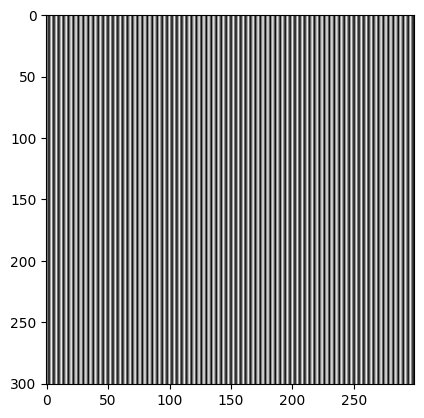

0.0037
0.33 0.67


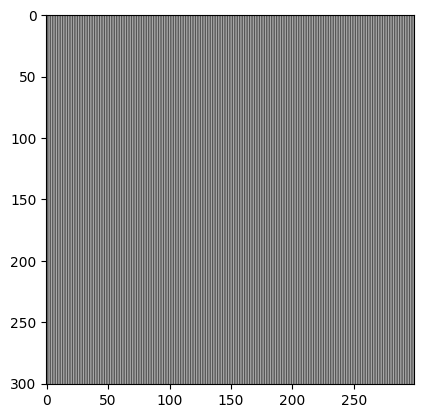

0.005217
0.32 0.68


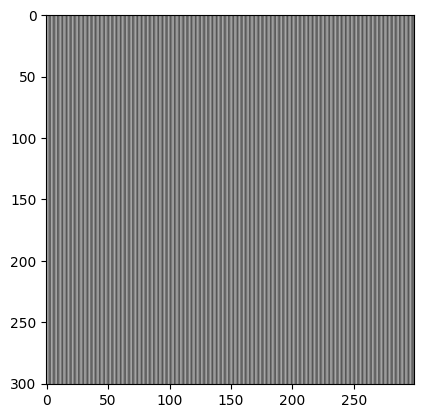

0.0074
0.5 0.5


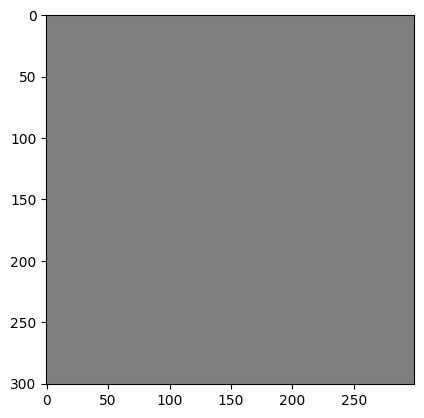

0.0111
0.44 0.56


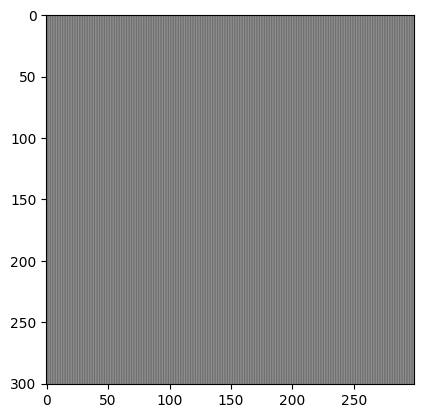

0.0148
0.5 0.5


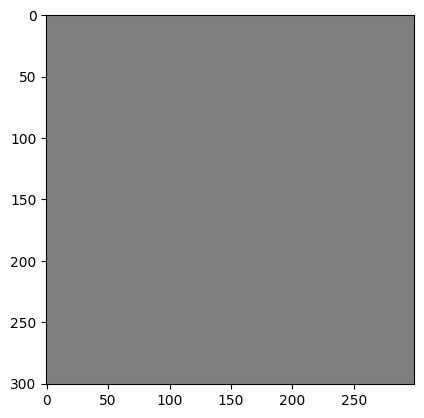

0.018500000000000003
0.47 0.53


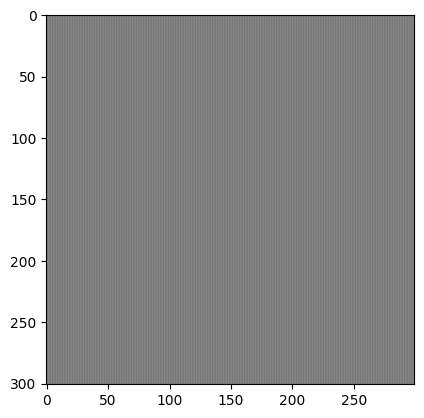

0.0222
0.5 0.5


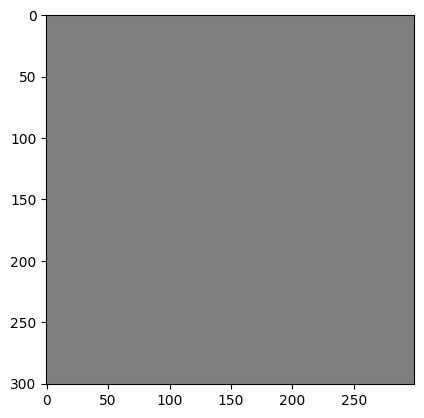

0.0259
0.48 0.52


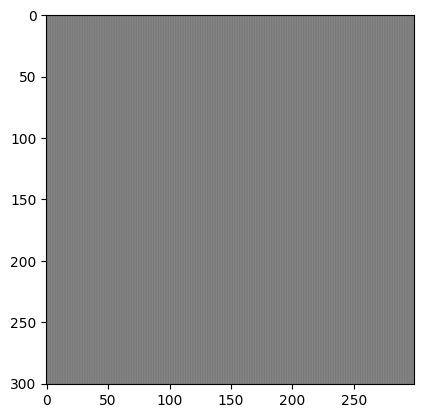

0.037000000000000005
0.5 0.5


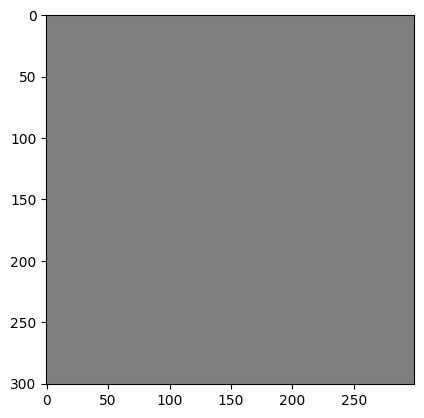

In [14]:
for i, par  in enumerate(pars):
    discretization(par*fs, 1)

In [15]:
# метрика MSE
def MSE(img1, img2):
    return np.mean((img1 - img2)**2)


In [16]:
# метрика PSNR
def PSNR(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = MSE(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [17]:
# метрика SSIM
def SSIM(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [18]:
def quantize_uniform(x, quant_min=0.0, quant_max=1.0, quant_level=2):
    
    x_normalize = (x-quant_min) * (quant_level-1) / (quant_max-quant_min)
    x_normalize[x_normalize > quant_level - 1] = quant_level - 1
    x_normalize[x_normalize < 0] = 0
    x_normalize_quant = np.around(x_normalize)
    x_quant = (x_normalize_quant) * (quant_max-quant_min) / (quant_level-1) + quant_min
    return x_quant


In [19]:
lvl_quant = [2, 8, 32, 64, 128, 256]

In [24]:
# 1 изображение 
def get_statistics(im, check = True, quant_min=0.0, quant_max=1.0):
    MSE_ = ['MSE']
    PSNR_ = ['PSNR']
    SSIM_ = ['SSIM']
    f  = plt.figure(figsize=(60,60))
    # отображение изображений
    for i, lvl in enumerate(lvl_quant):
        img = quantize_uniform(np.array(im),quant_min=quant_min, quant_max=quant_max, quant_level=lvl)
        MSE_.append(MSE(np.array(im), np.array(img)))
        PSNR_.append(PSNR(np.array(im), np.array(img)))
        SSIM_.append(ssim(np.array(img), np.array(im),data_range=img.max() - img.min()))

        f.add_subplot(1,13, i+1)
        plt.grid(False)
        if check:
            plt.imshow(get_mat(img), cmap='gray')
        else:
            plt.imshow(img, cmap='gray')
    # отображение метрик
    df = pd.DataFrame(({'func':[], 'LV_2': [], 'LV_8': [], 'LV_32': [],'LV_64': [], 'LV_128': [], 'LV_256': []}))
    df.loc[ len(df.index )] = MSE_
    df.loc[ len(df.index )] = PSNR_
    df.loc[ len(df.index )] = SSIM_
    plt.show()
    print(df)
    
    return df

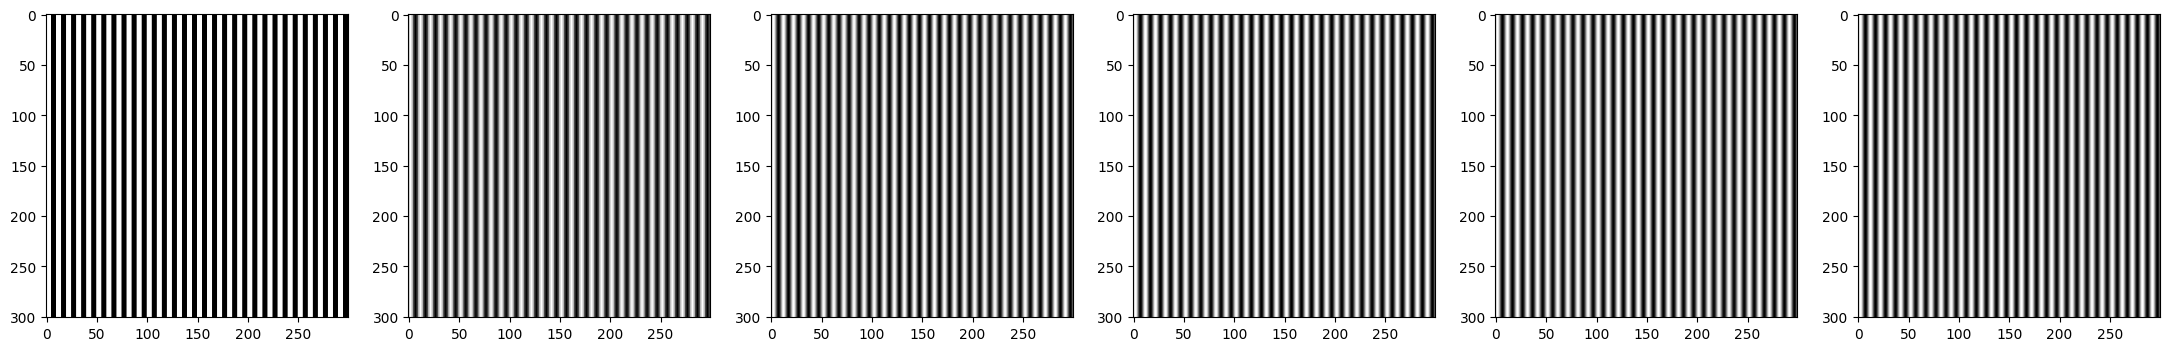

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.053020   0.002408   0.000034   0.000016   0.000008    0.000003
1  PSNR  60.886406  74.314680  92.876782  96.030105  99.014979  104.073627
2  SSIM   0.829357   0.986999   0.999838   0.999920   0.999956    0.999988


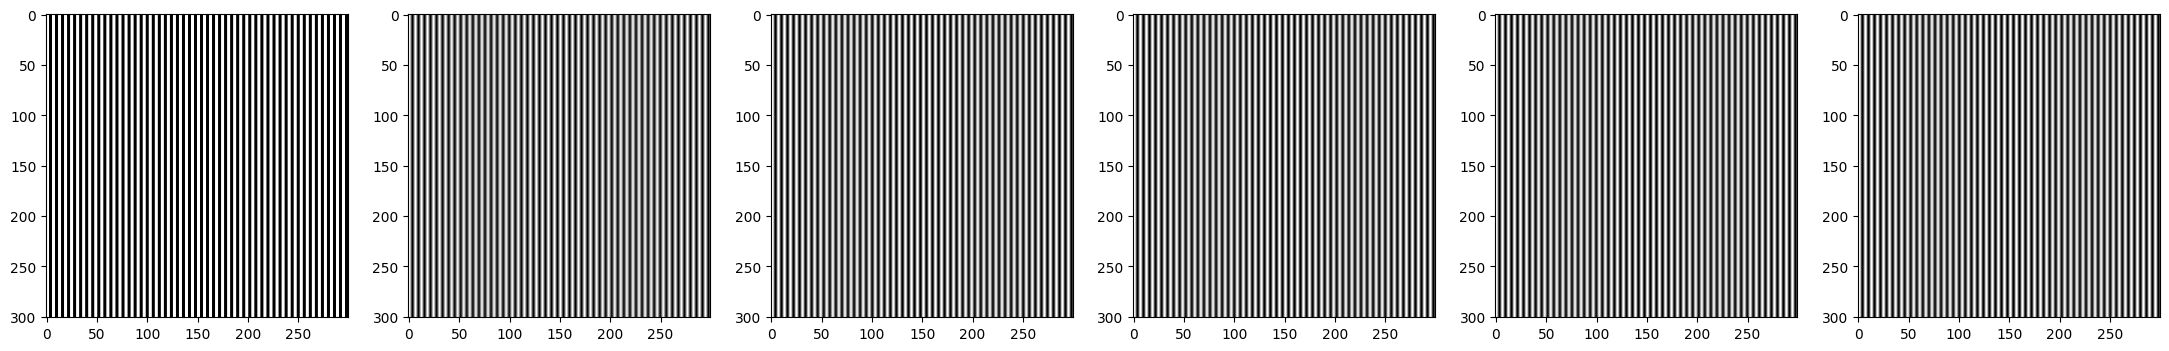

   func       LV_2       LV_8      LV_32     LV_64      LV_128        LV_256
0   MSE   0.045200   0.000574   0.000053   0.00003    0.000004  9.739844e-07
1  PSNR  61.579419  80.540552  90.922258  93.36945  101.706545  1.082453e+02
2  SSIM   0.874459   0.997451   0.999768   0.99987    0.999981  9.999957e-01


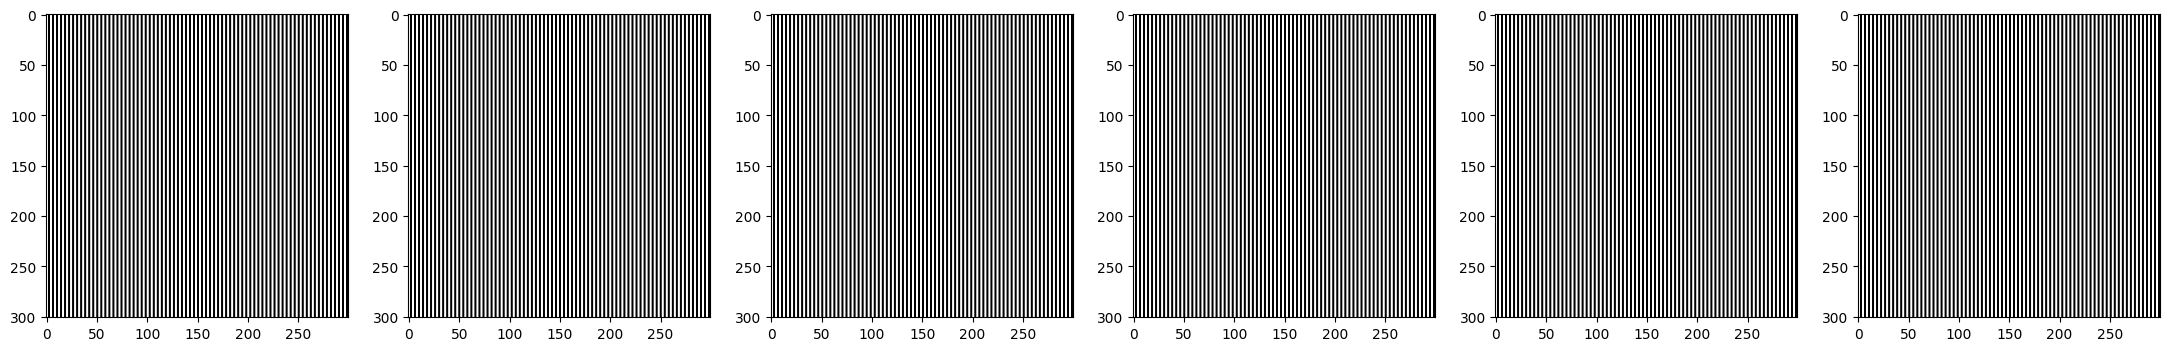

   func       LV_2       LV_8      LV_32      LV_64      LV_128        LV_256
0   MSE   0.032400   0.001380   0.000184   0.000029    0.000001  1.537870e-07
1  PSNR  63.025354  76.733297  85.493052  93.488036  107.284317  1.162616e+02
2  SSIM   0.907013   0.993953   0.999059   0.999859    0.999994  9.999992e-01


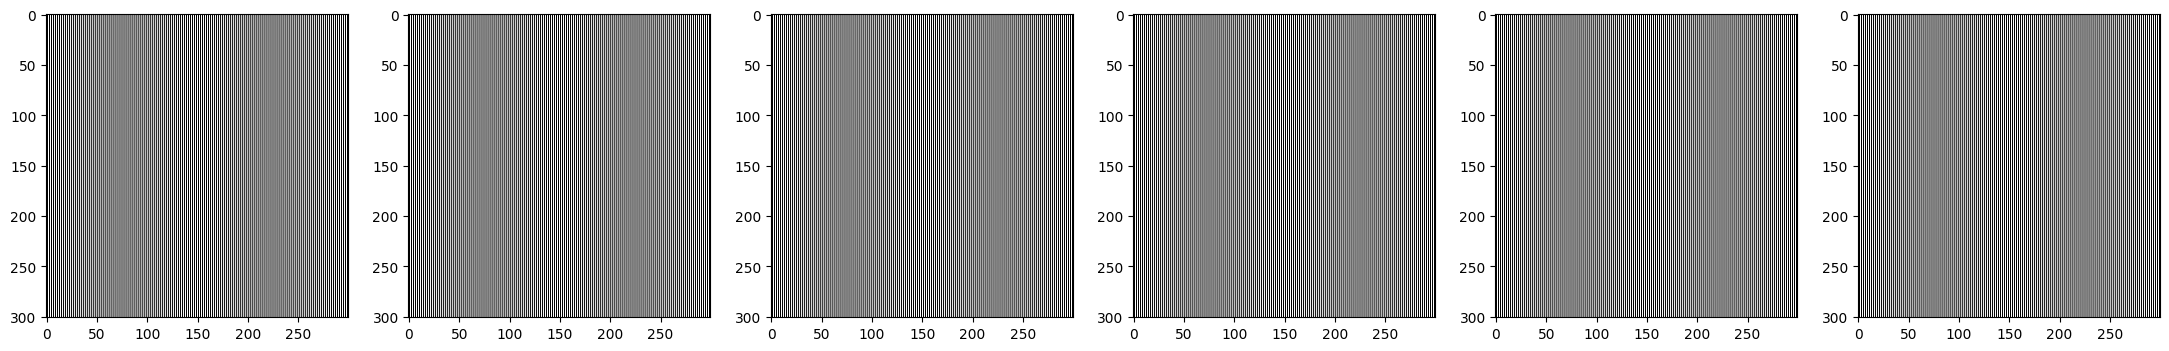

   func       LV_2       LV_8      LV_32      LV_64      LV_128        LV_256
0   MSE   0.032400   0.001380   0.000184   0.000029    0.000001  1.537870e-07
1  PSNR  63.025354  76.733297  85.493052  93.488036  107.284317  1.162616e+02
2  SSIM   0.907013   0.993953   0.999059   0.999859    0.999994  9.999992e-01


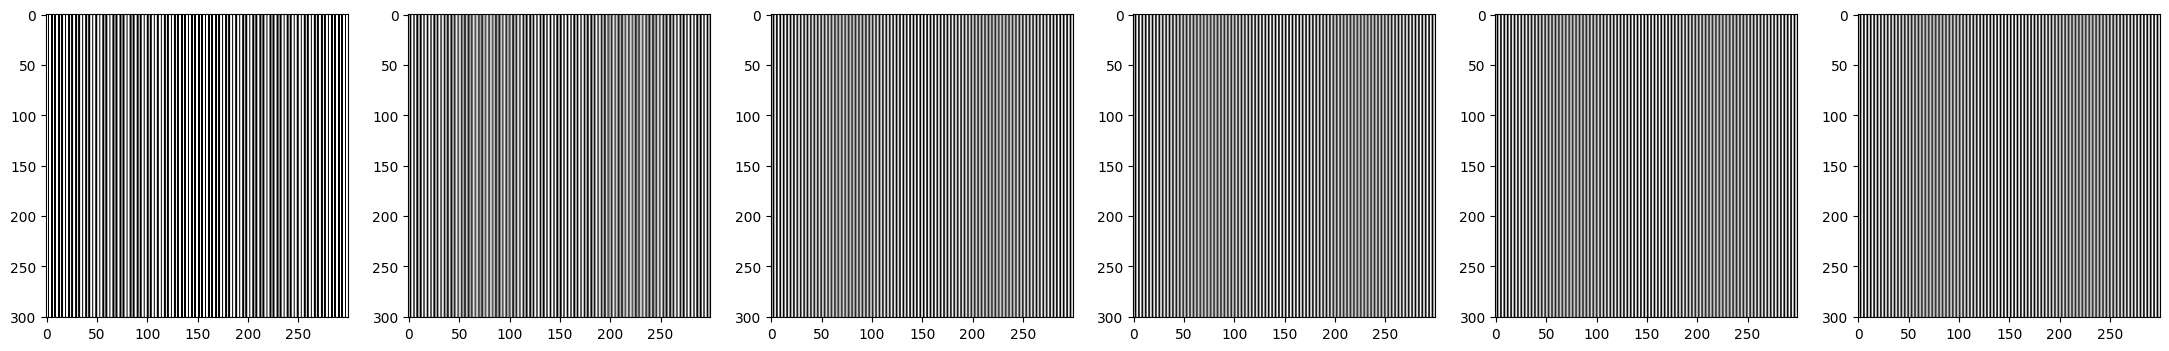

   func       LV_2       LV_8      LV_32      LV_64      LV_128      LV_256
0   MSE   0.151654   0.001997   0.000081   0.000019    0.000005    0.000001
1  PSNR  56.322265  75.127334  89.042997  95.382897  100.934920  106.848978
2  SSIM   0.435360   0.957462   0.997826   0.999472    0.999878    0.999963


/Users/dimka777/opt/anaconda3/envs/Mag/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


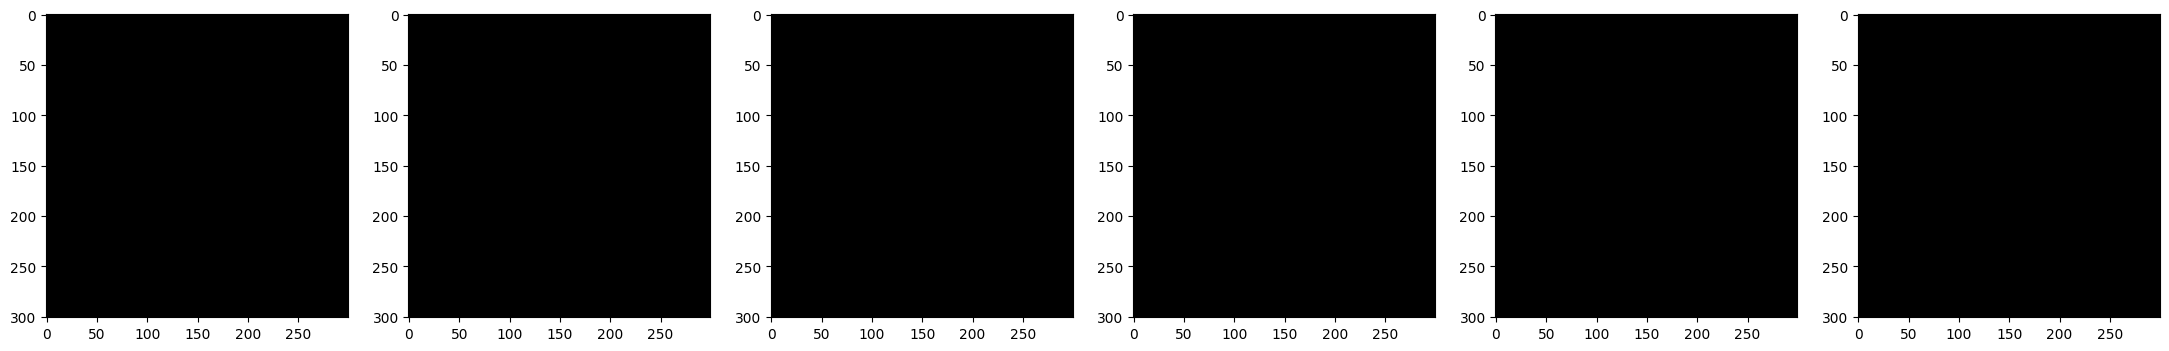

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.250000   0.005102   0.000260   0.000063   0.000016    0.000004
1  PSNR  54.151404  71.053364  83.978637  90.138215  96.227478  102.282207
2  SSIM        NaN   0.000000        NaN   0.000000        NaN         NaN


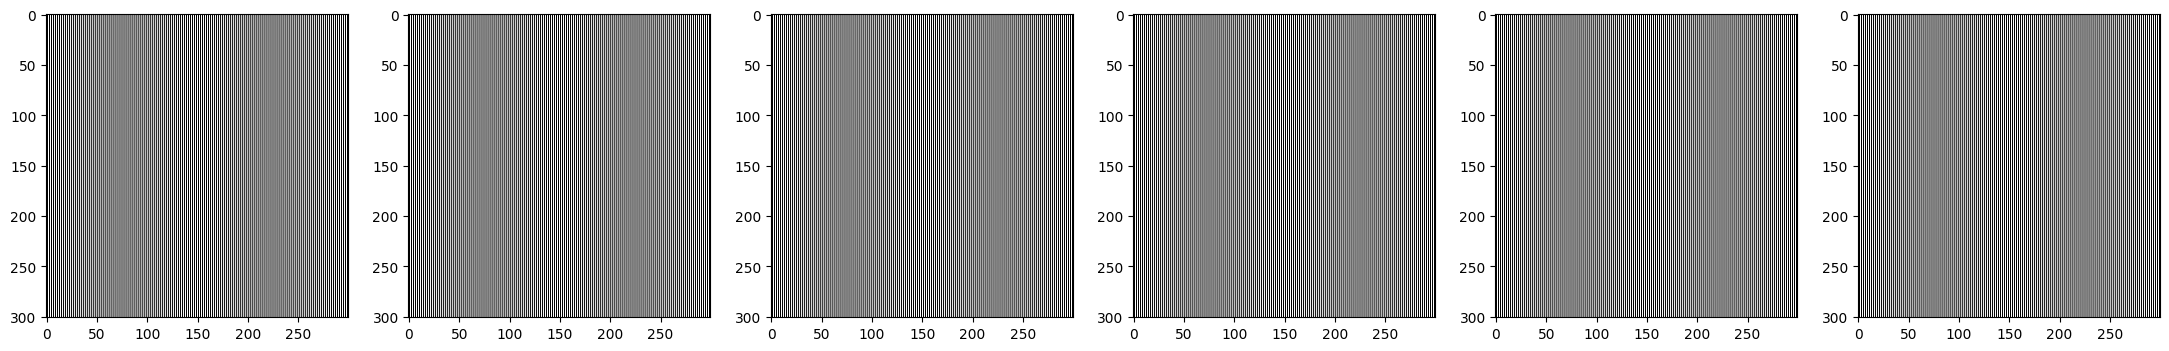

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.152100   0.001488   0.000008   0.000047   0.000014    0.000003
1  PSNR  56.309511  76.405489  98.873187  91.448245  96.764921  103.197357
2  SSIM   0.418758   0.913538   0.999661   0.997953   0.999415    0.999873


/Users/dimka777/opt/anaconda3/envs/Mag/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


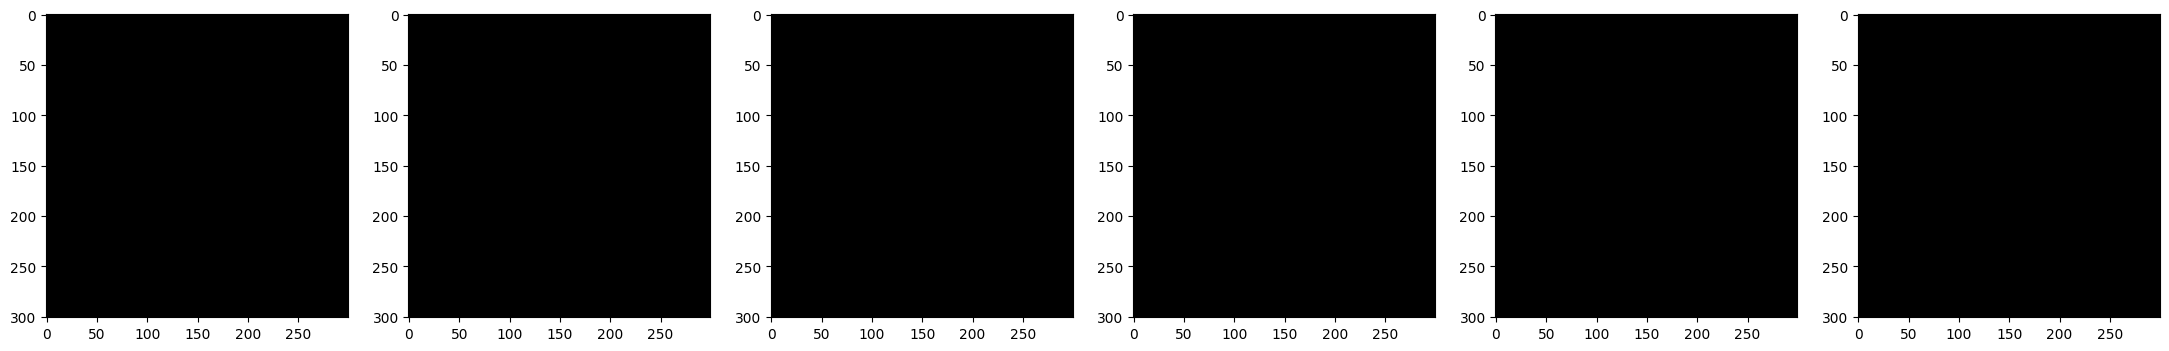

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.250000   0.005102   0.000260   0.000063   0.000016    0.000004
1  PSNR  54.151404  71.053364  83.978637  90.138215  96.227478  102.282207
2  SSIM        NaN   0.000000        NaN   0.000000        NaN         NaN


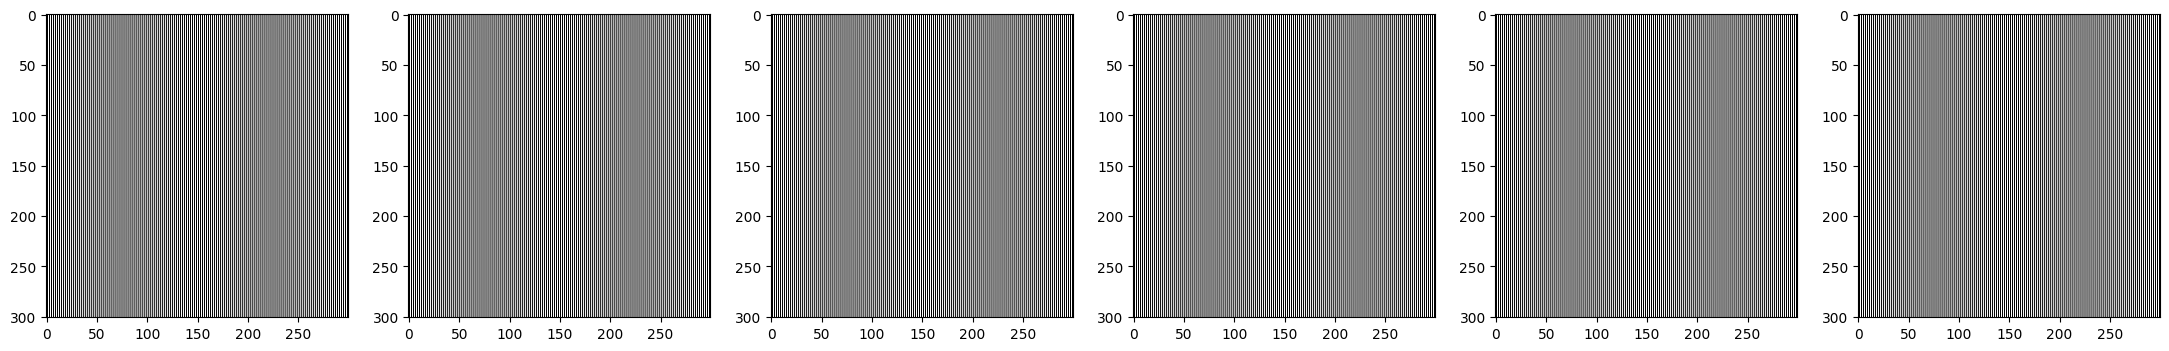

   func      LV_2       LV_8      LV_32      LV_64        LV_128        LV_256
0   MSE   0.19360   0.000131   0.000135   0.000020  8.928018e-07  6.151480e-07
1  PSNR  55.26175  86.970965  86.831987  95.174454  1.086233e+02  1.102410e+02
2  SSIM   0.23704   0.985013   0.977324   0.997049  9.998742e-01  9.999158e-01


/Users/dimka777/opt/anaconda3/envs/Mag/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


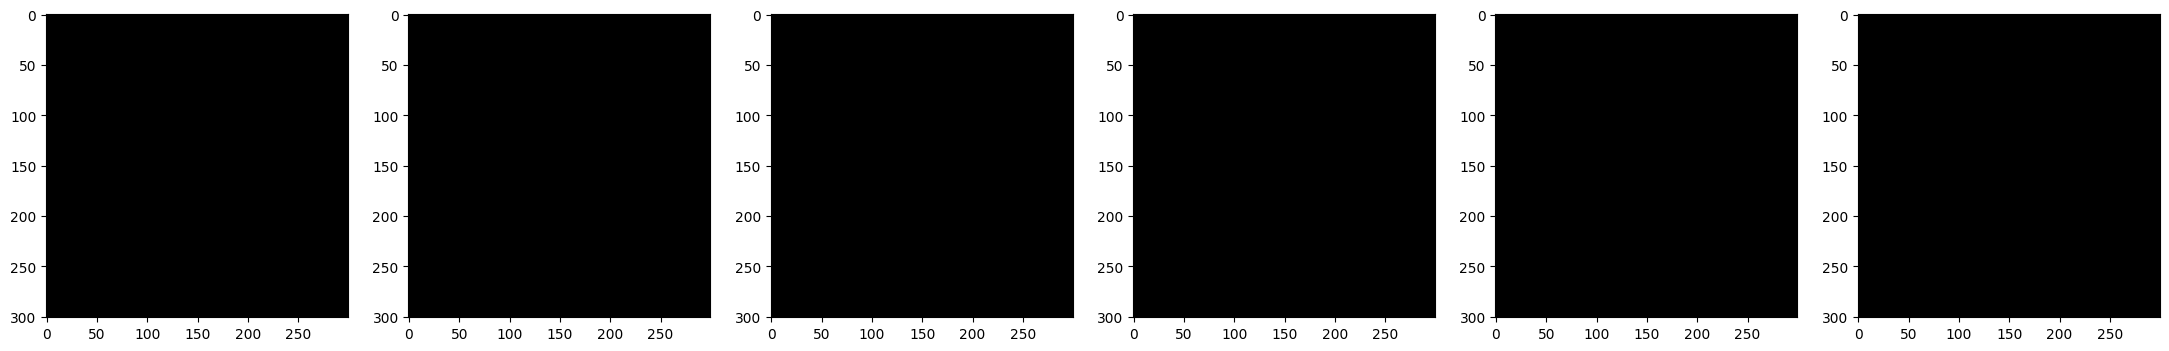

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.250000   0.005102   0.000260   0.000063   0.000016    0.000004
1  PSNR  54.151404  71.053364  83.978637  90.138215  96.227478  102.282207
2  SSIM        NaN   0.000000        NaN   0.000000        NaN         NaN


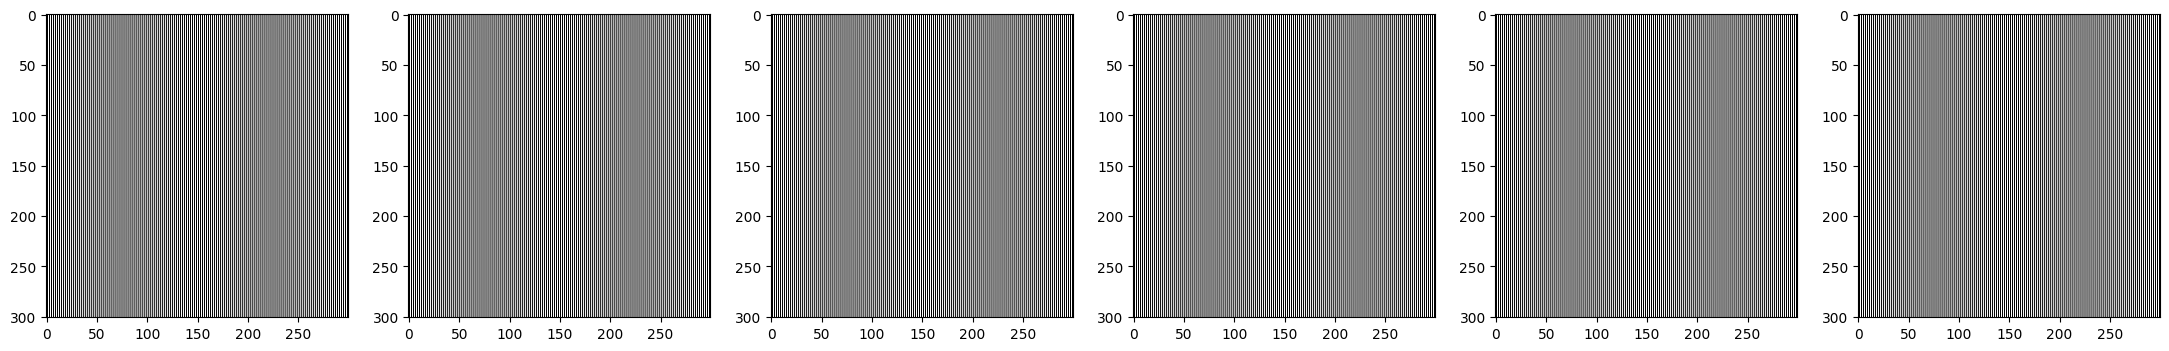

   func       LV_2       LV_8       LV_32      LV_64      LV_128        LV_256
0   MSE   0.202500   0.000459    0.000003   0.000031    0.000001  9.611688e-07
1  PSNR  55.066553  81.510939  103.978637  93.236254  106.685053  1.083028e+02
2  SSIM   0.198833   0.939707    0.999463   0.994483    0.999728  9.998042e-01


/Users/dimka777/opt/anaconda3/envs/Mag/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


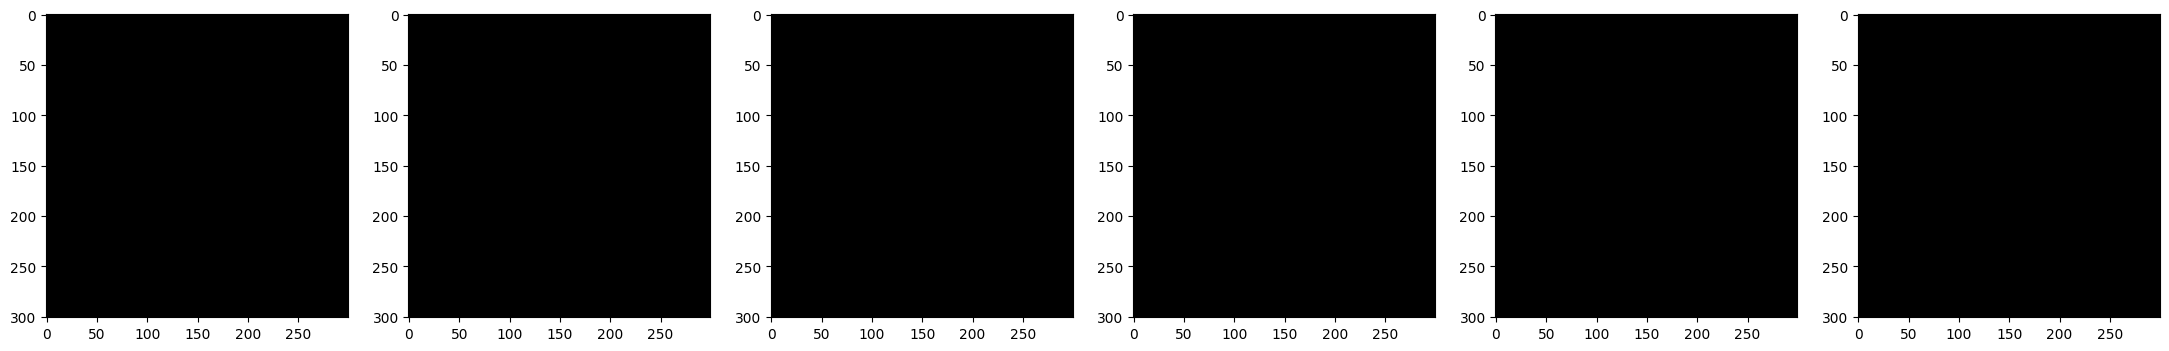

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.250000   0.005102   0.000260   0.000063   0.000016    0.000004
1  PSNR  54.151404  71.053364  83.978637  90.138215  96.227478  102.282207
2  SSIM        NaN   0.000000        NaN   0.000000        NaN         NaN


In [25]:
list_df = []
for im in list_sample:
    list_df.append(get_statistics(im))

In [66]:
def quantize_nonuniform_mu(x, mu=255.0, quant_level=256):
    def encoding_mu_law(v, mu=255.0):

        v_encode = np.sign(v) * (np.log(1.0 + mu * np.abs(v)) / np.log(1.0 + mu))
        return v_encode

    def decoding_mu_law(v, mu=255.0):
        
        v_decode = np.sign(v) * (1.0 / mu) * ((1.0 + mu)**np.abs(v) - 1.0)
        return v_decode

    x_en = encoding_mu_law(x, mu=mu)
    x_en_quant = quantize_uniform(x_en, quant_min=-1, quant_max=1, quant_level=quant_level)
    x_quant = decoding_mu_law(x_en_quant, mu=mu)
    return x_quant

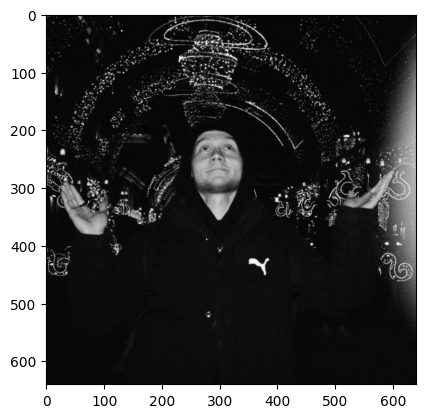

In [64]:
image_path = '/Users/dimka777/Documents/Магистратура/Mag_2_semester/ImageProcessing/PW_3/images/image_1.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap = 'gray')

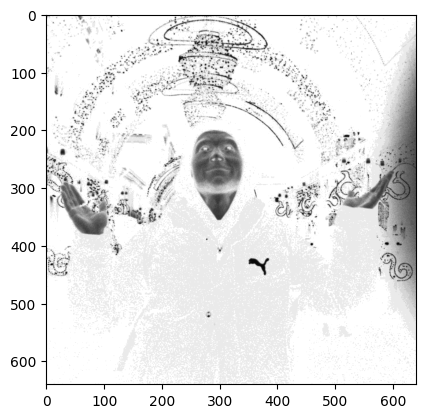

In [88]:
df_img=quantize_nonuniform_mu(image,mu = 255, quant_level =128)
plt.imshow(df_img, cmap ='gray')